In [1]:
# Importing Dependecies

# Importing Matplotlib for graohs and charts
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Importing Pandas for calculations
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and ORM. These dependencies will help us make a connection form the sqlite file to python or vice versa
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

# Reflect Tables into SQLAlchemy ORM

In [4]:
# create engine to hawaii.sqlite
# The two dots allows us to navigate a level within the directory. Cunnretly we are working in the SurfsUp
# directory therefore we want to go up one level which will then change our directory to the whole
# SQLAlchemy-Challenge directory
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# Setting up for reflecting data from sqlite file.
# We will then start setting down our structure in duplicating/reflecting the sqlite file referenced in
# the engine
Base = automap_base()
# The code below is going to reflect the tables and values within the referenced sqlite file into SQLAlchemy
Base.prepare(autoload_with=engine, reflect=True)
# Determining and seeing which tables to refect in reference to sqlite file.
# Once the tables have been reflected, we then want to see the tables that came with the sqlite file.
Base.classes.keys()

['measurement', 'station']

In [5]:
# reflect the tables
# Think of reflecting tables as creating a duplicate table but not actually creating a hard copy. More so
# it is being reflected to leave the orginal dataset alone and we will use the reflected tables to do 
# data cleaning, altering and so on if needed. More so, reflecting is just for viewing.
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
# Here we are creating a session. By creating a seesion we can then interact with the database using SQLAlchemy
# Basically allowing us to use python language
session = Session(engine)

# Exploratory Precipitation Analysis

In [7]:
# Find the most recent date in the data set.

# In order to find the recent date within the dataset, we can either print out the column names per table
# to help us identify which table stoers the date data or if both tables have date data. In this case we will
# be using the measurement table since it holds the only date data within the dataset.

# We want to create a variable which stores our query.
# The query states that using the measurement table's date column as reference we want to order it (the column)
# in descending order with only printing the first result.
recentdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"The most recent date within the dataset is {recentdate}")

The most recent date within the dataset is ('2017-08-23',)


            Precipitation
Date                     
2016-08-23           0.00
2016-08-23            NaN
2016-08-23           1.79
2016-08-23           0.05
2016-08-23           0.15
...                   ...
2017-08-22           0.00
2017-08-23           0.00
2017-08-23           0.00
2017-08-23           0.08
2017-08-23           0.45

[2230 rows x 1 columns]


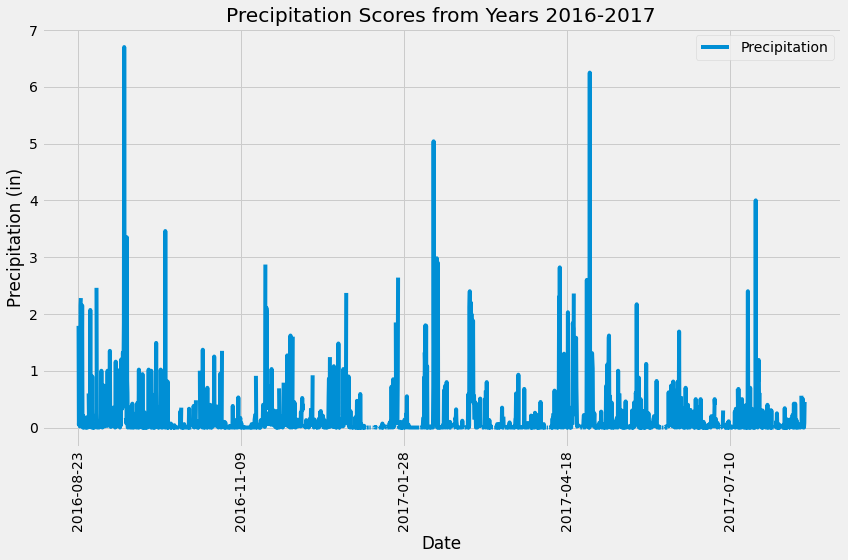

<Figure size 432x288 with 0 Axes>

In [24]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# In order to calculate the data one year prior to the earliest we will have to create a variable to store
# the result and use datetime library/package. We will take the printed result from the prior code 
# (most recent date) and subtracting it from the object (timedelta(days=365))

previousyear = dt.date(2017,8,23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores

# To answer this question we will create a query using the measurement table as references. Within the 
# measurement table, we want to specifically return data from the date and prcp columns. Specifically,
# between the most recent date and previous year from the most recent date.
results = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date >= previousyear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

# In order to plot we will first need to make a dataframe, therefore we will create a new variable and
# use the pd.DataFrame to create our dateframe, we want the results query (precipitation scores within
# 2016-2017) and set the columns of our newly created dataframe.

precipdf = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date

# The code below sets the "Date" column as the new index for the precipdf DataFrame, and 
precipdf.set_index('Date', inplace=True)
# The string of code below sorts the DataFrame by the index in ascending order
precipdf.sort_index(inplace=True)
print(precipdf)

# Use Pandas Plotting with Matplotlib to plot the data
precipdf.plot(rot=90, figsize=(12,8))
plt.xlabel("Date")
plt.ylabel("Precipitation (in)")
plt.title("Precipitation Scores from Years 2016-2017")
plt.tight_layout()
plt.show()

plt.savefig('PrecipitationGraph', dpi=100)

In [9]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = precipdf.describe()
print(summary)

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [10]:
# Design a query to calculate the total number stations in the dataset

# Using the station table as reference, the station column specifically, we want to count the unique values
# within the column.

stations = session.query(Station.station).distinct().count()
print(f"There are {stations} total stations within the dataset.")

There are 9 total stations within the dataset.


In [11]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

# To answer the question, we will refer to the measurement table's station column. Within that column we want
# to count the unique stations that appear within the dataset. From there we then want to group the it with
# the the same column because it instead of ussing the distinct function, by groupin the same column we can
# get one row for each unique station. Lastly, we then want to order the result in descending order based on
# how may times the station appears

session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [12]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Using the printed results from the code prior. We want to do some statistical analysis. We can do all of
# the desired analysis in one string by continuously calling 'func'. Once we finished writting out our 
# desired statistical analysis we then want to continue the string to only get the results from station
# USC00519281

session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

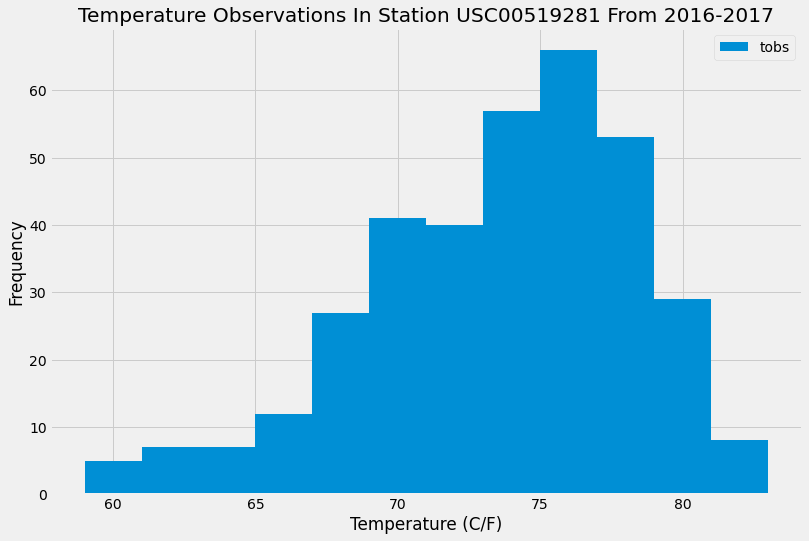

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= previousyear).all()
tempdf = pd.DataFrame(temp, columns=['tobs'])
tempdf.plot.hist(bins=12)
plt.title("Temperature Observations In Station USC00519281 From 2016-2017")
plt.xlabel("Temperature (C/F)")
plt.gcf().set_size_inches(12, 8)
plt.savefig('TemperatureObsevation', dpi=100)

# Close session

In [14]:
# Close Session
session.close()